## Logistic regression and neural network

- [Data processing](#data-processing)
- [Data loader](#data-loader)
- [Logistic regression](#logistic-regression)  
    - [Training](#training-logistic-regression)
    - [Training vs validation loss](#training-vs-validation-loss)
    - [Evaluation](#evaluation)
- [Early stopper](#early-stopper)
    - [Training with early stopper](#training-logistic-regression-with-early-stopper)
    - [Training vs validation loss](#training-vs-validation-loss-early-stop)
    - [Evaluation](#evaluation-early-stop)

## Data processing

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics  
import seaborn as sns

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed) 
    perm         = np.random.permutation(df.index)
    m            = len(df.index) 
    train_end    = int(np.floor(int(train_percent * m)))
    validate_end = int(np.floor(int(validate_percent * m) + train_end)) 
    
    train        = df.iloc[perm[:train_end]]
    validate     = df.iloc[perm[train_end:validate_end]]
    test         = df.iloc[perm[validate_end:]] 
 

    train       = train.reset_index(drop=True)
    validate    = validate.reset_index(drop=True)
    test        = test.reset_index(drop=True)
    
    return train, validate, test

### Data spliting and loading

In [2]:
foldername = "archive" 
df = pd.read_csv('%s/Student Depression Dataset.csv' % foldername)   
df.keys()

Index(['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [3]:
target_column = ['Depression']
feat_column   = [ 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness'] 

In [4]:
all_column =  target_column + feat_column
df = df[all_column]
df = df.apply(LabelEncoder().fit_transform)


train_df, test_df, valid_df = train_validate_test_split(df, train_percent=.8, validate_percent=.1, seed=None)

X_scaler = StandardScaler() 
train_df[feat_column].values[:]        = X_scaler.fit_transform(train_df[feat_column].values[:] )
test_df[feat_column].values[:]         = X_scaler.transform(test_df[feat_column].values[:] )
valid_df[feat_column].values[:]        = X_scaler.transform(valid_df[feat_column].values[:] )

print("# Training   dataset: %d" % len(train_df))
print("# Testing    dataset: %d" % len(test_df))
print("# Validating dataset: %d" % len(valid_df))

# Training   dataset: 22320
# Testing    dataset: 2790
# Validating dataset: 2791


In [5]:
all_column = target_column + feat_column
train_enc = train_df[all_column]

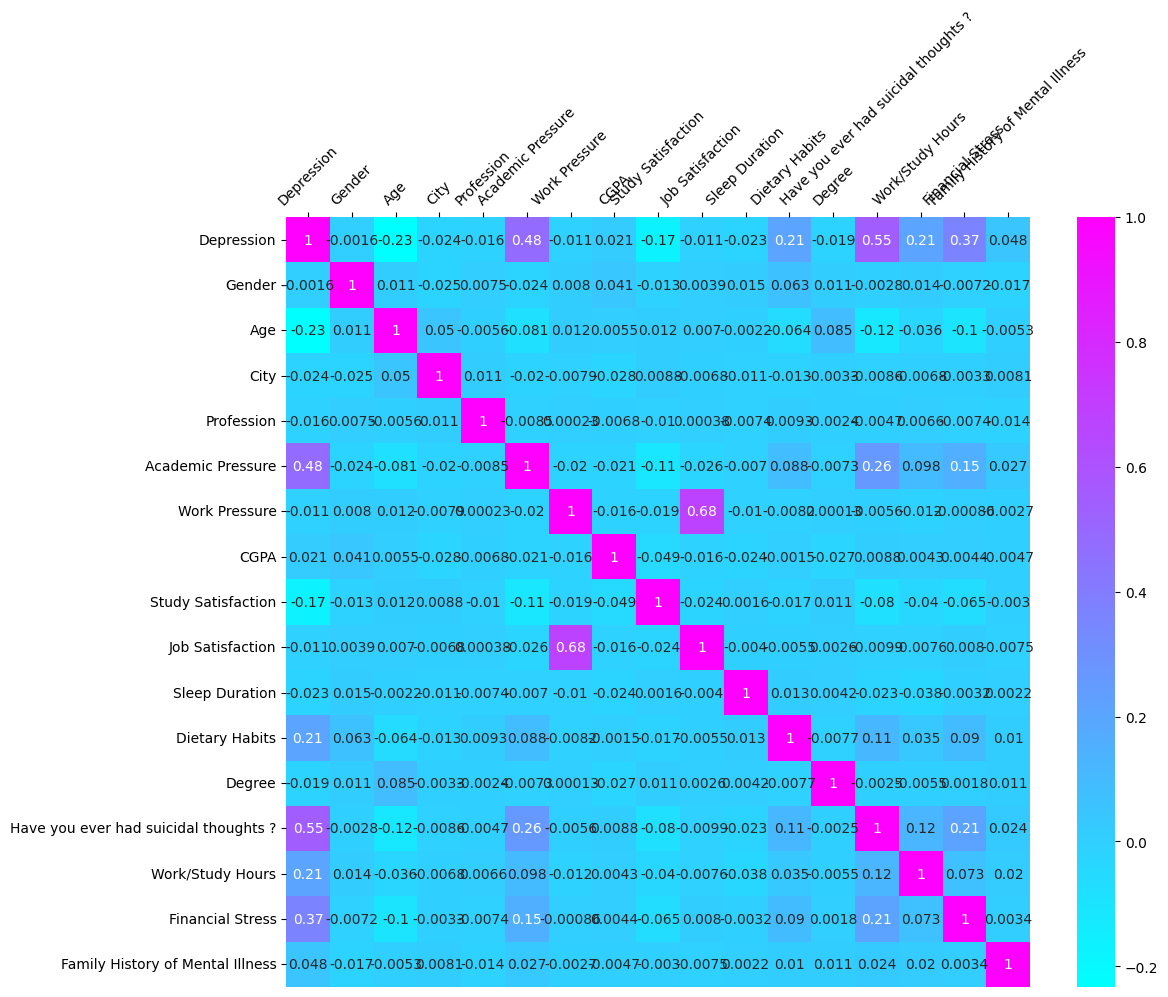

In [6]:
plt.figure(figsize=(12,10))
cor = train_enc.corr()
g = sns.heatmap(cor, annot=True, cmap=plt.cm.cool) 
g.axes.xaxis.set_ticks_position("top")
plt.setp(g.axes.get_xticklabels(), rotation=45)
plt.show()

## Data loader

In [7]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
 

class DataFrameDataset(Dataset):
    def __init__(self, df, features, target):
        self.df = df
        self.features = features
        self.target = target

        print("[Target = 1]: %d [Target = 0]: %d" % (len(df[target_column][(df[target_column].values == 1)]), len(df[target_column][(df[target_column].values == 0)])))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = torch.tensor(row[self.features].values).to(torch.float)
        y = torch.tensor(row[self.target].values).to(torch.float)
        return x, y
 
print("Num feat. column = %d" % len(feat_column))
train_set = DataFrameDataset(train_df, features=feat_column, target=target_column)
valid_set = DataFrameDataset(valid_df, features=feat_column, target=target_column)
test_set = DataFrameDataset(test_df, features=feat_column, target=target_column)


Num feat. column = 16
[Target = 1]: 13065 [Target = 0]: 9255
[Target = 1]: 1630 [Target = 0]: 1161
[Target = 1]: 1641 [Target = 0]: 1149


## Logistic regression

In [8]:
model_name = "LogisticReg"
class LogisticRegression(nn.Module):    
    # build the constructor
    def __init__(self, n_inputs, n_outputs=1):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_inputs, n_outputs)
    # make predictions
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [9]:
import torch.optim as optim 
from torchmetrics.classification import BinaryF1Score
import os 

model_folder   = "LogisticRegression-weights"
os.makedirs(model_folder, exist_ok=True)

n_inputs      =  len(feat_column)
learning_rate = 0.0005
max_epoch     = 50
batch_size    = 4
threshold     = 0.5

logistic_model = LogisticRegression(n_inputs, n_outputs=1) 
criterion      = nn.BCELoss()
F1_score       = BinaryF1Score() 
optimizer      = optim.Adam(logistic_model.parameters(), lr=learning_rate) 

validloader    = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=True)
testloader     = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

### Training logistic regression

In [10]:
from tqdm import tqdm

training_avg_bce_list = []
training_avg_f1_list = []

valid_avg_bce_list = []
valid_avg_f1_list = []


for epoch in range(max_epoch):  # loop over the dataset multiple times

    trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    pbar        = tqdm(trainloader)

    logistic_model.train()
    mode = "TRAIN"
    loss_list     = [] 
    f1_score_list = [] 
    
    for data in pbar:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data 

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predictions = logistic_model(inputs)

        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

        pred_binary = 1*(predictions  > threshold)

        f1_score = F1_score(pred_binary, labels)   
        f1_score_list.append(f1_score.item())
 
        pbar.set_description('%d [%s : %s] BIC Loss %0.3f, F1 score %0.3f' % (epoch, mode, model_name, sum(loss_list)/len(loss_list), sum(f1_score_list)/len(f1_score_list)))

    training_avg_bce_list.append(sum(loss_list)/len(loss_list))
    training_avg_f1_list.append(sum(f1_score_list)/len(f1_score_list))

    loss_list     = [] 
    f1_score_list = [] 
    mode = "VALID"
    logistic_model.eval()
    vpbar = tqdm(validloader)
    for i, data in enumerate(vpbar):
        inputs, labels = data

        with torch.no_grad():
            predictions = logistic_model(inputs)

        loss = criterion(predictions, labels)
        loss_list.append(loss.item()) 

        pred_binary = 1*(predictions  >= threshold)

        f1_score = F1_score(pred_binary, labels)   
        f1_score_list.append(f1_score.item()) 

        vpbar.set_description('%d [%s : %s] BIC Loss %0.3f, F1 score %0.3f' % (epoch, mode, model_name, sum(loss_list)/len(loss_list), sum(f1_score_list)/len(f1_score_list)))

    valid_avg_bce_list.append(sum(loss_list)/len(loss_list))
    valid_avg_f1_list.append(sum(f1_score_list)/len(f1_score_list))

    if (epoch % 2) == 0:  
        torch.save(logistic_model.state_dict(), '%s/%s.pth' % (model_folder, model_name))

        

0 [TRAIN : LogisticReg] BIC Loss 0.691, F1 score 0.725: 100%|██████████| 5580/5580 [00:10<00:00, 513.03it/s]
0 [VALID : LogisticReg] BIC Loss 0.425, F1 score 0.795: 100%|██████████| 697/697 [00:01<00:00, 581.93it/s]
1 [TRAIN : LogisticReg] BIC Loss 0.388, F1 score 0.815: 100%|██████████| 5580/5580 [00:10<00:00, 520.04it/s]
1 [VALID : LogisticReg] BIC Loss 0.377, F1 score 0.818: 100%|██████████| 697/697 [00:01<00:00, 568.74it/s]
2 [TRAIN : LogisticReg] BIC Loss 0.367, F1 score 0.826: 100%|██████████| 5580/5580 [00:10<00:00, 518.09it/s]
2 [VALID : LogisticReg] BIC Loss 0.380, F1 score 0.791: 100%|██████████| 697/697 [00:01<00:00, 570.89it/s]
3 [TRAIN : LogisticReg] BIC Loss 0.360, F1 score 0.823: 100%|██████████| 5580/5580 [00:10<00:00, 512.70it/s]
3 [VALID : LogisticReg] BIC Loss 0.374, F1 score 0.794: 100%|██████████| 697/697 [00:01<00:00, 582.29it/s]
4 [TRAIN : LogisticReg] BIC Loss 0.358, F1 score 0.828: 100%|██████████| 5580/5580 [00:10<00:00, 519.85it/s]
4 [VALID : LogisticReg] BIC

### Training vs validation loss

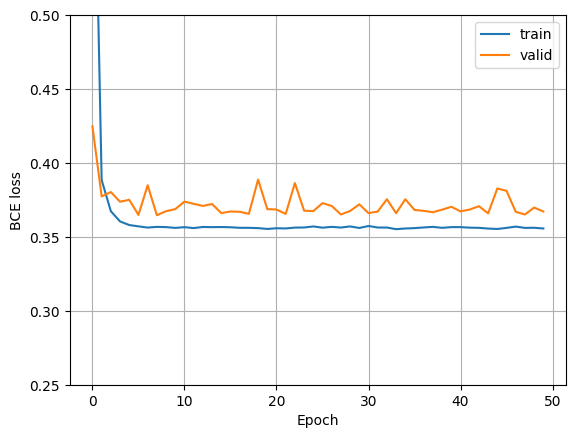

In [11]:
import matplotlib.pyplot as plt

x_value = range(len(training_avg_bce_list))
plt.plot(x_value, training_avg_bce_list, label="train")
plt.plot(x_value, valid_avg_bce_list, label="valid")
plt.ylim([0.25,0.5])
plt.ylabel("BCE loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid()
plt.show()

### Evaluation

In [12]:
Load_weight_path = '%s/%s.pth' % (model_folder, model_name)
logistic_model.load_state_dict(torch.load(Load_weight_path, weights_only=True))

<All keys matched successfully>

In [13]:
mode = "TEST"
logistic_model.eval()
tpbar = tqdm(testloader)
for i, data in enumerate(tpbar):
    input_images, labels = data

    with torch.no_grad():
        predictions = logistic_model(input_images.view(batch_size,-1))

    loss = criterion(predictions, labels)  
    loss_list.append(loss.item()) 

    f1_score = F1_score(predictions, labels)  
    f1_score_list.append(f1_score.item()) 

    tpbar.set_description('[%s : %s] BIC Loss %0.3f, F1 score %0.3f' % (mode, model_name, sum(loss_list)/len(loss_list), sum(f1_score_list)/len(f1_score_list)))

[TEST : LogisticReg] BIC Loss 0.365, F1 score 0.826: 100%|██████████| 697/697 [00:01<00:00, 584.57it/s]


## Early stopper

In [14]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.ep      = 0
        self.min_validation_loss = float('inf')
        self.weight  = torch.empty((1,1), dtype=torch.int64)

    def check(self, weight, ep, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.weight = weight
            self.ep     = ep
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Training logistic regression with early stopper

In [15]:
import torch.optim as optim 
from torchmetrics.classification import BinaryF1Score
import os 

model_folder   = "LogisticRegression-weights-earlystopper"
os.makedirs(model_folder, exist_ok=True)

n_inputs      =  len(feat_column)
learning_rate = 0.0005
max_epoch     = 50
batch_size    = 4
threshold     = 0.5

logistic_model = LogisticRegression(n_inputs, n_outputs=1) 
criterion      = nn.BCELoss()
F1_score       = BinaryF1Score() 
optimizer      = optim.Adam(logistic_model.parameters(), lr=learning_rate)  

Earlystoper    = EarlyStopper(patience=5)

validloader    = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=True)
testloader     = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

In [16]:
from tqdm import tqdm

training_avg_bce_list = []
training_avg_f1_list = []

valid_avg_bce_list = []
valid_avg_f1_list = []


for epoch in range(max_epoch):  # loop over the dataset multiple times

    trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    pbar        = tqdm(trainloader)

    logistic_model.train()
    mode = "TRAIN"
    loss_list     = [] 
    f1_score_list = [] 
    
    for data in pbar:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data 

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predictions = logistic_model(inputs)

        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

        pred_binary = 1*(predictions  > threshold)

        f1_score = F1_score(pred_binary, labels)   
        f1_score_list.append(f1_score.item())
 
        pbar.set_description('%d [%s : %s] BIC Loss %0.3f, F1 score %0.3f' % (epoch, mode, model_name, sum(loss_list)/len(loss_list), sum(f1_score_list)/len(f1_score_list)))

    training_avg_bce_list.append(sum(loss_list)/len(loss_list))
    training_avg_f1_list.append(sum(f1_score_list)/len(f1_score_list))

    loss_list     = [] 
    f1_score_list = [] 
    mode = "VALID"
    logistic_model.eval()
    vpbar = tqdm(validloader)
    for i, data in enumerate(vpbar):
        inputs, labels = data

        with torch.no_grad():
            predictions = logistic_model(inputs)

        loss = criterion(predictions, labels)
        loss_list.append(loss.item()) 

        pred_binary = 1*(predictions  >= threshold)

        f1_score = F1_score(pred_binary, labels)   
        f1_score_list.append(f1_score.item()) 

        vpbar.set_description('%d [%s : %s] BIC Loss %0.3f, F1 score %0.3f' % (epoch, mode, model_name, sum(loss_list)/len(loss_list), sum(f1_score_list)/len(f1_score_list)))

    valid_avg_bce_list.append(sum(loss_list)/len(loss_list))
    valid_avg_f1_list.append(sum(f1_score_list)/len(f1_score_list))

    stopping_criterion_met = Earlystoper.check(logistic_model.state_dict(), epoch,  sum(loss_list)/len(loss_list))

    if stopping_criterion_met:  
        torch.save(Earlystoper.weight, '%s/%s.pth' % (model_folder, model_name))
        break 

        

0 [TRAIN : LogisticReg] BIC Loss 1.261, F1 score 0.692: 100%|██████████| 5580/5580 [00:10<00:00, 516.35it/s]
0 [VALID : LogisticReg] BIC Loss 0.444, F1 score 0.772: 100%|██████████| 697/697 [00:01<00:00, 558.73it/s]
1 [TRAIN : LogisticReg] BIC Loss 0.400, F1 score 0.816: 100%|██████████| 5580/5580 [00:11<00:00, 507.24it/s]
1 [VALID : LogisticReg] BIC Loss 0.384, F1 score 0.816: 100%|██████████| 697/697 [00:01<00:00, 582.66it/s]
2 [TRAIN : LogisticReg] BIC Loss 0.372, F1 score 0.819: 100%|██████████| 5580/5580 [00:10<00:00, 515.22it/s]
2 [VALID : LogisticReg] BIC Loss 0.372, F1 score 0.809: 100%|██████████| 697/697 [00:01<00:00, 544.46it/s]
3 [TRAIN : LogisticReg] BIC Loss 0.363, F1 score 0.823: 100%|██████████| 5580/5580 [00:10<00:00, 522.54it/s]
3 [VALID : LogisticReg] BIC Loss 0.368, F1 score 0.823: 100%|██████████| 697/697 [00:01<00:00, 580.02it/s]
4 [TRAIN : LogisticReg] BIC Loss 0.358, F1 score 0.825: 100%|██████████| 5580/5580 [00:10<00:00, 518.95it/s]
4 [VALID : LogisticReg] BIC

### Training vs validation loss (early stop)

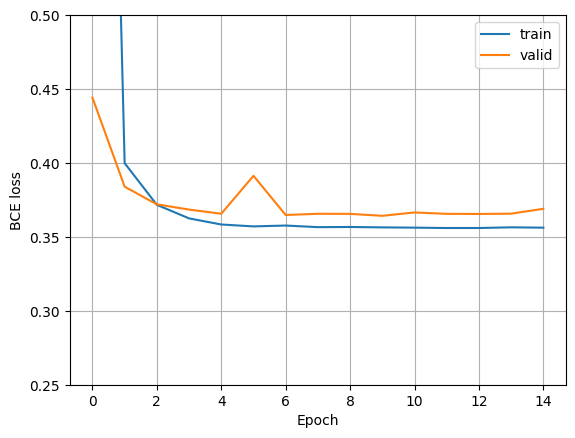

In [17]:
import matplotlib.pyplot as plt

x_value = range(len(training_avg_bce_list))
plt.plot(x_value, training_avg_bce_list, label="train")
plt.plot(x_value, valid_avg_bce_list, label="valid")
plt.ylim([0.25,0.5])
plt.ylabel("BCE loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid()
plt.show()

### Evaluation (early stop)

In [18]:
Load_weight_path = '%s/%s.pth' % (model_folder, model_name)
logistic_model.load_state_dict(torch.load(Load_weight_path, weights_only=True))

<All keys matched successfully>

In [19]:
mode = "TEST"
logistic_model.eval()
tpbar = tqdm(testloader)
for i, data in enumerate(tpbar):
    input_images, labels = data

    with torch.no_grad():
        predictions = logistic_model(input_images.view(batch_size,-1))

    loss = criterion(predictions, labels)  
    loss_list.append(loss.item()) 

    f1_score = F1_score(predictions, labels)  
    f1_score_list.append(f1_score.item()) 

    tpbar.set_description('[%s : %s] BIC Loss %0.3f, F1 score %0.3f' % (mode, model_name, sum(loss_list)/len(loss_list), sum(f1_score_list)/len(f1_score_list)))

[TEST : LogisticReg] BIC Loss 0.365, F1 score 0.833: 100%|██████████| 697/697 [00:01<00:00, 578.31it/s]
